# Graphs

This notebook is adapted from Chapter 2 of [Think Complexity](https://greenteapress.com/wp/think-complexity-2e/).

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/graph.ipynb)

## Graph

A graph is a collection of nodes and edges, where nodes often represent objects or ideas, and edges represent relationships among them.
For example, in a graph that represents a social network, nodes might represent people and edges might represent friendships between them.

NetworkX provides data structures to represent graphs and function that implement graph algorithms.
To show how it works, we'll make a small graph that represents a social network.

Here's how we make a graph and add nodes. 

In [1]:
import networkx as nx

G = nx.Graph()
G.add_node('Alice')
G.add_node('Bob', age=23)
G.add_node('Carol', cat='mittens')
list(G.nodes())

['Alice', 'Bob', 'Carol']

Optionally, you can provide attributes that are associated with the node. In this example, Bob has an `age` attribute and Carol has a cat.

Here's how we add edges between nodes. 

In [2]:
G.add_edge('Alice', 'Bob')
G.add_edge('Alice', 'Carol', type='enemy')
list(G.edges())

[('Alice', 'Bob'), ('Alice', 'Carol')]

Optionally, you can provide attributes that are associated with the edge.
In this example, the second edge has an attribute called `type` that indicates the nature of the relationship.

Here's how to draw the graph.

In [3]:
def draw_graph(G):
    nx.draw_circular(G, node_size=1500, with_labels=True)

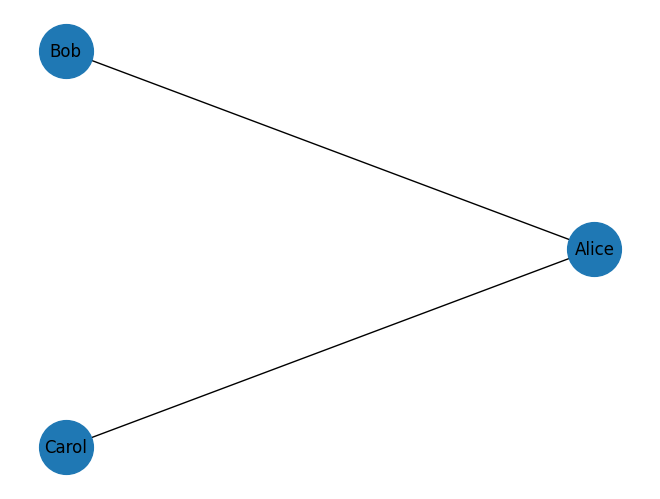

In [4]:
draw_graph(G)

**Exercise:**  Suppose Alice introduces Bob and Carol, and they become frenemies. Update the social network by adding an edge between Bob and Carol with an appropriate attribute, then draw the graph  again.

[('Alice', 'Bob'), ('Alice', 'Carol'), ('Bob', 'Carol')]


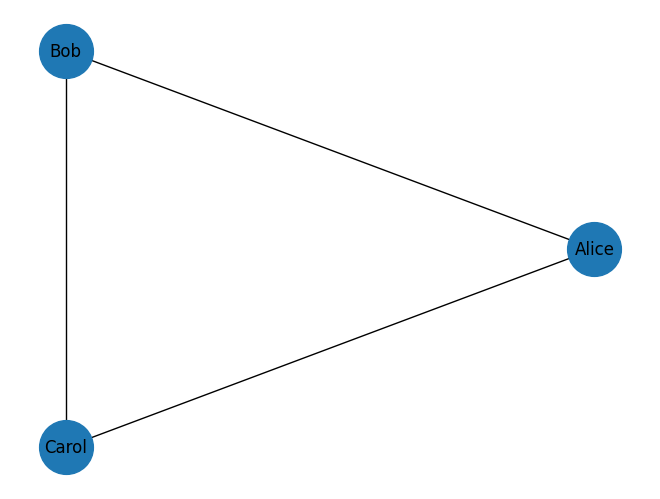

In [5]:
G.add_edge("Bob", "Carol", type = "frenemy")
print(G.edges)
G.edges[('Bob', 'Carol')]
draw_graph(G)

## Graph Representation

NetworkX represents graphs using a dictionary that maps from each node to a dictionary that maps from nodes to edges.

If we select an element from the top-level dictionary, the result is a dictionary-like object.

In [6]:
G['Alice']

AtlasView({'Bob': {}, 'Carol': {'type': 'enemy'}})

So we can iterate through the neighbors of a node like this:

In [7]:
for neighbor in G['Alice']:
    print(neighbor)

Bob
Carol


Or enumerate the neighbors and edges like this:

In [8]:
for key, value in G['Alice'].items():
    print(key, value)

Bob {}
Carol {'type': 'enemy'}


Edges are represented by dictionaries of attributes. In this example, the first edge has no attributes and the second has an attribute named `type`.

We can select an edge like this:

In [9]:
G['Alice']['Carol']

{'type': 'enemy'}

To check whether there is an edge from one node to another, we can use the `in` operator:

In [10]:
def has_edge(G, u, v):
    return v in G[u]

In [11]:
has_edge(G, 'Alice', 'Bob')

True

But there's a method that does the same thing.

In [12]:
G.has_edge('Alice', 'Bob')

True

## Complete graph

In a complete graph, all nodes are connected to each other.
To make a complete graph, we'll use the following generator function, iterates through all pairs of nodes.

In [13]:
def counter(n):
    for i in range(n):
        yield i
vals = counter(10)


In [14]:
next(vals)

0

In [15]:
def all_pairs(nodes):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

Here's a complete graph with 10 nodes:

In [16]:
def make_complete_graph(n):
    nodes = range(n)
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(all_pairs(nodes))
    return G

In [17]:
complete = make_complete_graph(5)

And here's what it looks like.

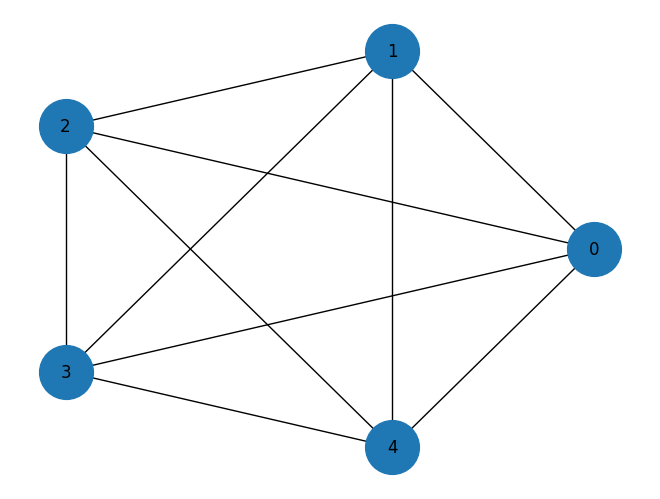

In [18]:
draw_graph(complete)

## Random graphs

Next we'll make an Erdos-Renyi graph, which is a random graph where the probability of an edge between each pair of nodes is $p$.

The helper function `flip` returns `True` with probability `p` and `False` with probability `1-p`

In [19]:
import random

def flip(p):
    return random.random() < p

`random_pairs` is a generator function that enumerates all possible pairs of nodes and yields each one with probability `p` 

In [20]:
def random_pairs(nodes, p):
    for edge in all_pairs(nodes):
        if flip(p):
            yield edge

`make_random_graph` makes an ER graph where the probability of an edge between each pair of nodes is `p`.

In [21]:
def make_random_graph(n, p):
    nodes = range(n)
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(random_pairs(nodes, p))
    return G

Here's an example with `n=10` and `p=0.3`

In [22]:
random_graph = make_random_graph(5, 0.5)
len(random_graph.edges())

6

And here's what it looks like:

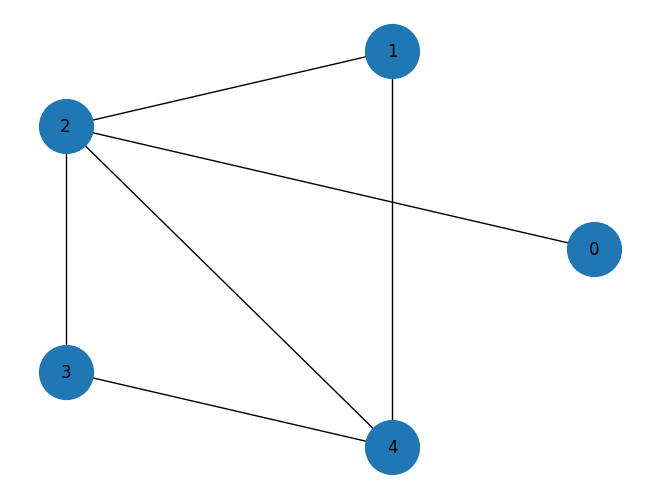

In [23]:
draw_graph(random_graph)

## Connectivity

A graph is **connected** if you can start from any node and follow a sequence of edges to reach any other node.

To check whether a graph is connected, we'll use a version of a depth-first search.
First, let's see what goes wrong with a basic DFS; then we'll fix the problem.

In [24]:
h = set()
h.add(1)
h
1 in h
set('abracadabra')

{'a', 'b', 'c', 'd', 'r'}

In [25]:
def basic_dfs(G, start):
    stack = [start]
    seen = set()

    while stack:
        node = stack.pop()
        seen.add(node)
        # print(node)
        stack.extend(n for n in G[node] if n not in seen)
    return seen

In [26]:
basic_dfs(random_graph, 0)

{0, 1, 2, 3, 4}

For most graphs, the basic version of DFS runs forever, because it visits the same nodes over and over.
The solution is to keep track of the nodes we've seen and avoid visiting them more than once.

**Exercise:** Write a function called `reachable_nodes` that takes a graph and a starting node, uses DFS to find all nodes that can be reached from the starting node, and returns a collection that contains them.

Hint: Think about what kind of collection to use.

In [27]:
# Solution

def reachable_nodes(G, start):
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(G[node])
    return seen

In the complete graph, starting from node 0, we can reach all nodes:

In [28]:
reachable_nodes(complete, 0)

{0, 1, 2, 3, 4}

In a random graph, it may or may not be possible to reach all nodes.

In [29]:
reachable_nodes(random_graph, 0)

{0, 1, 2, 3, 4}

So we can use `reachable_nodes` to check whether a graph is connected:

In [30]:
def is_connected(G):
    start = next(iter(G))
    reachable = reachable_nodes(G, start)
    return len(reachable) == len(G)

Again, the complete graph is connected:

In [31]:
is_connected(complete)

True

If we generate a random graph with a low value of `p`, it's probably not connected.

In [32]:
random_graph = make_random_graph(10, 0.1)
len(random_graph.edges())

9

In [33]:
is_connected(random_graph)

False

If we generate a random graph with a high value of `p`, it's probably not connected.

In [34]:
random_graph = make_random_graph(10, 0.9)
len(random_graph.edges())

36

In [35]:
is_connected(random_graph)

True

## Probability of connectivity

This behavior is the topic of a [seminal paper in network science](https://www.renyi.hu/~p_erdos/1960-10.pdf).
We can use NetworkX and the functions we've written to replicate one of their results.

The following function takes `n` and `p`, generates `iters` graphs, and returns the fraction of them that are connected.

In [36]:
import numpy as np

def prob_connected(n, p, iters=100):
    tf = [is_connected(make_random_graph(n, p))
          for i in range(iters)]
    return np.mean(tf)

With `n=10` and `p=0.23`, the probability of being connected is about 33%.

In [37]:
n = 10
prob_connected(n, 0.23, iters=10000)

0.3467

According to Erdos and Renyi, the critical value of `p` for `n=10` is about 0.23. 

In [38]:
pstar = np.log(n) / n
pstar

0.23025850929940458

So let's plot the probability of connectivity for a range of values for `p`

In [39]:
ps = np.logspace(-1.3, 0, 11)
ps

array([0.05011872, 0.0676083 , 0.09120108, 0.12302688, 0.16595869,
       0.22387211, 0.30199517, 0.40738028, 0.54954087, 0.74131024,
       1.        ])

I'll estimate the probabilities with `iters=1000`

In [40]:
ys = [prob_connected(n, p, 1000) for p in ps]

for p, y in zip(ps, ys):
    print(p, y)

0.05011872336272722 0.0
0.06760829753919818 0.0
0.09120108393559097 0.006
0.12302687708123815 0.018
0.16595869074375605 0.109
0.22387211385683395 0.306
0.3019951720402016 0.641
0.40738027780411273 0.905
0.5495408738576245 0.994
0.7413102413009173 1.0
1.0 1.0


And then plot them, adding a vertical line at the computed critical value

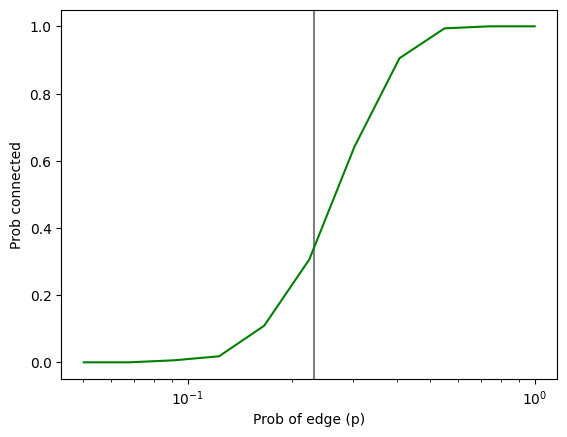

In [41]:
import matplotlib.pyplot as plt

plt.axvline(pstar, color='gray')
plt.plot(ps, ys, color='green')
plt.xlabel('Prob of edge (p)')
plt.ylabel('Prob connected')
plt.xscale('log')

**Exercise:** In my implementation of `reachable_nodes`, you might be bothered by the apparent inefficiency of adding *all* neighbors to the stack without checking whether they are already in `seen`.  Write a version of this function that checks the neighbors before adding them to the stack.  Does this "optimization" change the order of growth?  Does it make the function faster?

In [42]:
# Solution

"""Checking the nodes before putting them on the stack does not affect the order 
of growth; we have to perform the same number of checks either way.  But it might 
be a little faster because it avoids the overhead of adding and removing nodes 
from the stack over and over."""

def reachable_nodes_precheck(G, start):
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            stack.extend(neighbors)
    return seen

In [43]:
complete = make_complete_graph(100)

In [44]:
%timeit len(reachable_nodes(complete, 0))

372 µs ± 5.91 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [45]:
%timeit len(reachable_nodes_precheck(complete, 0))

420 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


How does the performance of the two methods compare for larger values of `n`?

*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [ ]:
# Python function to greet a user
def greet(name):
    print(f"Hello, {name}!")

greet('Will')
